In [ ]:
! git clone https://github.com/Das-Abhi/covid-detection-x-ray  # for dataset, it is a private repo 

Cloning into 'covid-detection-x-ray'...
remote: Enumerating objects: 21168, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 21168 (delta 8), reused 42 (delta 8), pack-reused 21126
Receiving objects: 100% (21168/21168), 826.03 MiB | 27.18 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Checking out files: 100% (21192/21192), done.


In [ ]:
# Data preprocessing
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from glob import glob
from PIL import Image
import os
import random
import cv2
#Model
import keras
import tensorflow as tf
from keras.models import Sequential, Model,load_model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalMaxPooling2D, BatchNormalization
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras import regularizers
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator,array_to_img
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from keras.metrics import PrecisionAtRecall,Recall 
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
#Model Analysis
from sklearn.metrics import confusion_matrix

In [ ]:
path = '/content/covid-detection-x-ray/COVID-19_Radiography_Dataset/'

diag_code_dict = {
    'COVID': 0,
    'Lung_Opacity': 1,
    'Normal': 2,
    'Viral Pneumonia': 3}

diag_title_dict = {
    'COVID': 'Covid-19',
    'Lung_Opacity': 'Lung Opacity',
    'Normal': 'Healthy',
    'Viral Pneumonia': 'Viral Pneumonia'}

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*','*.png'))}

covidData = pd.DataFrame.from_dict(imageid_path_dict, orient = 'index').reset_index()
covidData.columns = ['image_id','path']
classes = covidData.image_id.str.split('-').str[0]
covidData['diag'] = classes
covidData['target'] = covidData['diag'].map(diag_code_dict.get) 
covidData['Class'] = covidData['diag'].map(diag_title_dict.get) 

In [ ]:
samples,features = covidData.shape
duplicated = covidData.duplicated().sum()
null_values = covidData.isnull().sum().sum()

print('Basic EDA')
print('Number of samples: %d'%(samples))
print('Number of duplicated values: %d'%(duplicated))
print('Number of Null samples: %d' % (null_values))

Basic EDA
Number of samples: 21165
Number of duplicated values: 0
Number of Null samples: 0


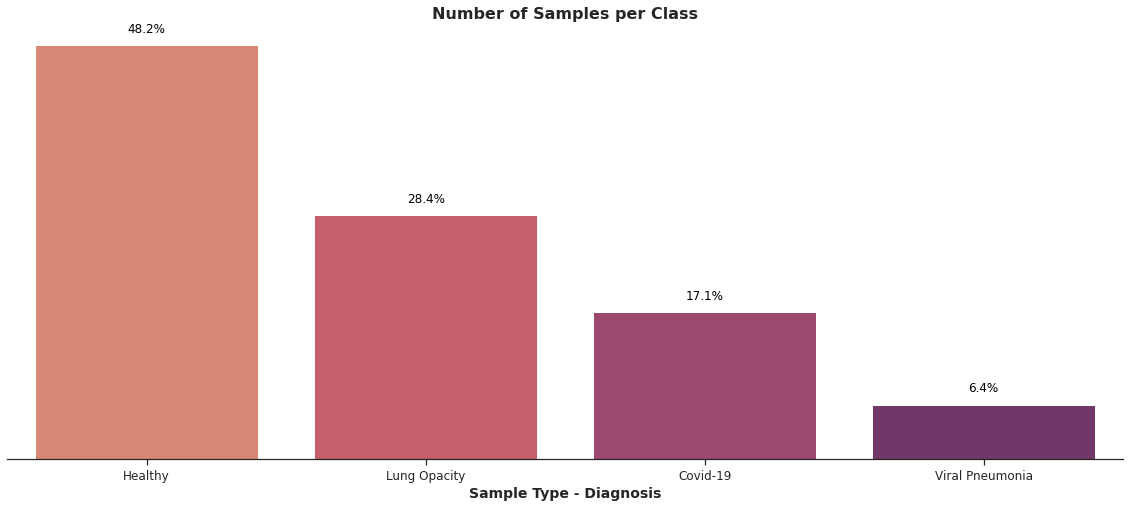

In [ ]:
#Samples per class
plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.countplot(data = covidData,x='Class',order = covidData['Class'].value_counts().index,palette="flare")
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Sample Type - Diagnosis',fontsize = 14,weight = 'bold')
ax.set(yticklabels=[])
ax.axes.get_yaxis().set_visible(False) 
plt.title('Number of Samples per Class', fontsize = 16,weight = 'bold');
#Plot numbers
for p in ax.patches:
    ax.annotate("%.1f%%" % (100*float(p.get_height()/samples)), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
    ha='center', va='bottom', color='black', xytext=(0, 10),rotation = 'horizontal',
    textcoords='offset points')

In [ ]:
covidData['image'] = covidData['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

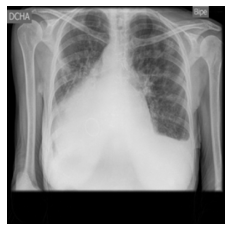

In [ ]:
plt.figure()
pic_id = random.randrange(0, samples)
picture = covidData['path'][pic_id]
image = cv2.imread(picture)
plt.imshow(image)
plt.axis('off');
plt.show()

## Model Creation

In [ ]:
#add the path general where the classes subpath are allocated
path = '/content/covid-detection-x-ray/COVID-19_Radiography_Dataset'

classes=["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]
#classes=["COVID",  "Normal"]
num_classes = len(classes)
batch_size=32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


#load the images to training
train_generator = train_datagen.flow_from_directory(directory=path, 
                                              target_size=(299, 299),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True, classes=classes,
                                              batch_size=batch_size, 
                                              color_mode="grayscale")
#load the images to test
validation_generator = val_datagen.flow_from_directory(directory=path, 
                                              target_size=(299, 299),
                                              class_mode='categorical',
                                              subset='validation',
                                              shuffle=False, classes=classes,
                                              batch_size=batch_size, 
                                              color_mode="grayscale")

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


### Model-1 Resnet-50

In [ ]:
base_model = tf.keras.applications.ResNet50(include_top=False,weights='imagenet',pooling='avg')

model = Sequential([
  Conv2D(3,(3,3), padding='same', input_shape=(224,224,1)),
  base_model,
  Dense(4, activation='softmax'),
])
opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 3)       30        
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 8196      
Total params: 23,595,938
Trainable params: 23,542,818
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
epochs = 10
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights1.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5)
callbacks = [checkpoint, reduce_lr,early_stopping]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

Epoch 1/10
529/529 [==============================] - 393s 666ms/step - loss: 0.5657 - accuracy: 0.7965 - val_loss: 1.2840 - val_accuracy: 0.2846

Epoch 00001: saving model to model_weights1.h5
Epoch 2/10
529/529 [==============================] - 353s 667ms/step - loss: 0.2952 - accuracy: 0.8960 - val_loss: 1.3893 - val_accuracy: 0.4304

Epoch 00002: saving model to model_weights1.h5
Epoch 3/10
529/529 [==============================] - 353s 666ms/step - loss: 0.2379 - accuracy: 0.9143 - val_loss: 2.1401 - val_accuracy: 0.5135

Epoch 00003: saving model to model_weights1.h5
Epoch 4/10
529/529 [==============================] - 353s 667ms/step - loss: 0.1698 - accuracy: 0.9389 - val_loss: 0.1525 - val_accuracy: 0.9420

Epoch 00004: saving model to model_weights1.h5
Epoch 5/10
529/529 [==============================] - 353s 666ms/step - loss: 0.1386 - accuracy: 0.9514 - val_loss: 0.2023 - val_accuracy: 0.9283

Epoch 00005: saving model to model_weights1.h5
Epoch 6/10
529/529 [==========

In [ ]:
y_pred = model.predict(validation_generator)

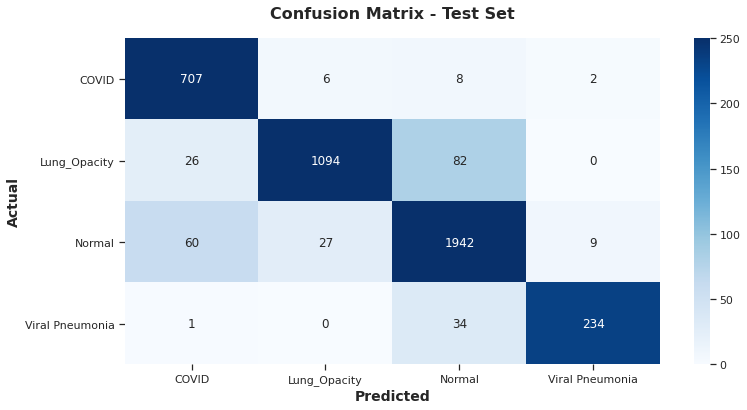

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))
y_true=validation_generator.classes
CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)
len(y_true)
plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

keras.backend.clear_session()

**Overall Results**
Accuracy Result: 93.97%
Precision Result: 93.91%
Recall Result: 92.77%
F-Score Result: 93.21%


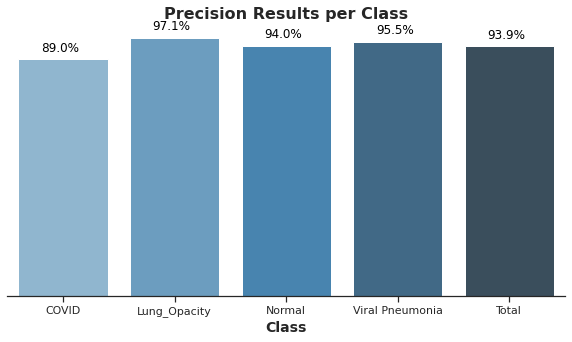

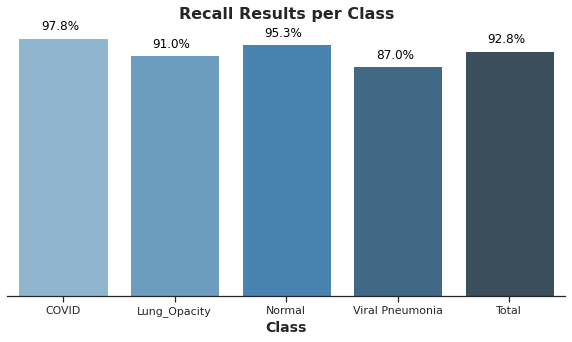

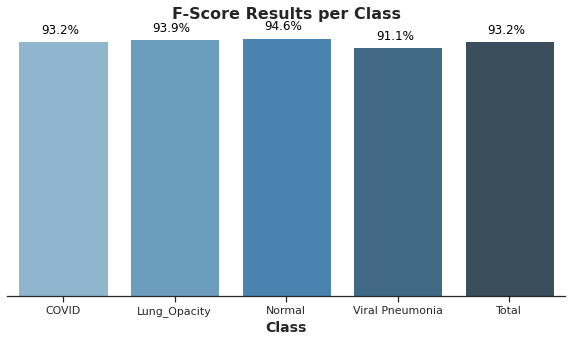

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

acc = accuracy_score(y_true, predictions)
results_all = precision_recall_fscore_support(y_true, predictions, average='macro',zero_division = 1)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division = 1)

metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia','Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(10,5))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')
metrics_plot(all_df, 'Recall')
metrics_plot(all_df, 'F-Score')
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100))
print('Precision Result: %.2f%%'%(all_df.iloc[4,0]*100))
print('Recall Result: %.2f%%'%(all_df.iloc[4,1]*100))
print('F-Score Result: %.2f%%'%(all_df.iloc[4,2]*100))